# Feature Selection for D-Features

## import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

## load data

In [2]:
dataframe = pd.read_csv('data/all_D_features.csv')
dataframe.head()

,Unnamed: 0,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,isFraud
0,0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,0
1,1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0
2,2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,0
3,3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,0
4,4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## remove useless column (row ID?)

In [3]:
dataframe = dataframe.drop('Unnamed: 0', axis=1)
dataframe.head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,isFraud
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,0
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,0
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## define utility function to reduce memory usage

In [4]:
def reduce_mem_usage(df, verbose=True):
    """
    Reduce dataframe size

    params:
    - df: dataframe to reduce the size of

    return:
    - dataframe of reduced size
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'float128']
    start_mem = df.memory_usage().sum() / 1024**2    

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float64).min and c_max < np.finfo(np.float64).max:
                    df[col] = df[col].astype(np.float64)
                elif c_min > np.finfo(np.float128).min and c_max < np.finfo(np.float128).max:
                    df[col] = df[col].astype(np.float128)
                    
    end_mem = df.memory_usage().sum() / 1024**2

    if verbose: 
        print(
            'Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(
            end_mem, 100 * (start_mem - end_mem) / start_mem
        ))

    return df

## reduce dataframe size to reduce memory usage

In [5]:
reduce_mem_usage(dataframe)

Mem. usage decreased to 17.46 Mb (75.8% reduction)


,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,isFraud
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,0
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,0
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,29.0,29.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,56.0,56.0,NaN,NaN,NaN,56.0,0
590536,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0
590537,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0
590538,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,22.0,NaN,NaN,NaN,22.0,0


## check percentage NaNs in each column

In [6]:
for column in dataframe.columns:
    num_nans = dataframe[column].isna().sum()
    print('percentage of NaNs for {}: {:.3f}'.format(
        column, 
        num_nans / len(dataframe) * 100
    ))

percentage of NaNs for D1: 0.215
percentage of NaNs for D2: 47.549
percentage of NaNs for D3: 44.515
percentage of NaNs for D4: 28.605
percentage of NaNs for D5: 52.467
percentage of NaNs for D6: 87.607
percentage of NaNs for D7: 93.410
percentage of NaNs for D8: 87.312
percentage of NaNs for D9: 87.312
percentage of NaNs for D10: 12.873
percentage of NaNs for D11: 47.293
percentage of NaNs for D12: 89.041
percentage of NaNs for D13: 89.509
percentage of NaNs for D14: 89.469
percentage of NaNs for D15: 15.090
percentage of NaNs for isFraud: 0.000


## remove columns with a lot of NaNs

- if we do imputation when there is a lot of NaNs, the imputed value may not be representative of actual value

In [7]:
# keep columns with less than 60% NaNs
dataframe = dataframe.loc[:, dataframe.isna().mean() < 0.6]
dataframe.head()

,D1,D2,D3,D4,D5,D10,D11,D15,isFraud
0,14.0,NaN,13.0,NaN,NaN,13.0,13.0,0.0,0
1,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0
2,0.0,NaN,NaN,0.0,NaN,0.0,315.0,315.0,0
3,112.0,112.0,0.0,94.0,0.0,84.0,NaN,111.0,0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## define function for drawing correlation heatmap

In [8]:
def draw_correlation_heatmap(df):
    """
    params:
    - df: dataframe of which correlation heatmap is drawn
    """
    fig, ax = plt.subplots(figsize=(10,10))

    sns.heatmap(
        df.corr(), 
        vmax=1.0, 
        center=0, 
        fmt='.2f',
        square=True, 
        linewidths=0.5, 
        annot=True, 
        cbar_kws={'shrink': .70},
    )

    plt.show()

## draw correlation heatmap to check for correlated features

- correlated features may affect classifier performance

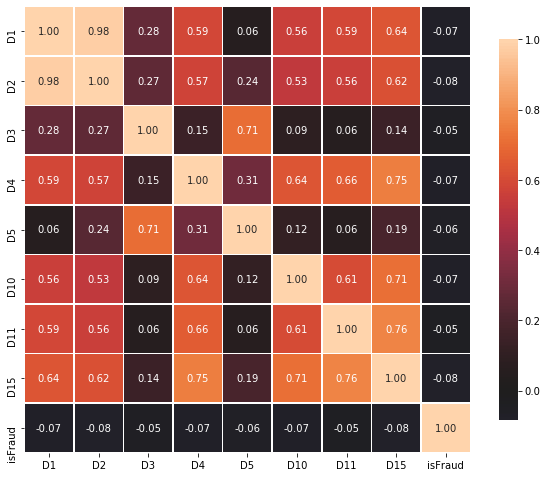

In [9]:
draw_correlation_heatmap(dataframe)

## drop highly-correlated features

In [10]:
dataframe = dataframe.drop(['D2'], axis=1)
dataframe.head()

,D1,D3,D4,D5,D10,D11,D15,isFraud
0,14.0,13.0,NaN,NaN,13.0,13.0,0.0,0
1,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0
2,0.0,NaN,0.0,NaN,0.0,315.0,315.0,0
3,112.0,0.0,94.0,0.0,84.0,NaN,111.0,0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0


## do imputation to fill in NaNs

In [11]:
# replace NaN with interquartile mean
dataframe = dataframe.fillna(dataframe.quantile().mean())
dataframe.head()

,D1,D3,D4,D5,D10,D11,D15,isFraud
0,14.0,13.000,19.625,19.625,13.000,13.000,0.000,0
1,0.0,19.625,0.000,19.625,0.000,19.625,0.000,0
2,0.0,19.625,0.000,19.625,0.000,315.000,315.000,0
3,112.0,0.000,94.000,0.000,84.000,19.625,111.000,0
4,0.0,19.625,19.625,19.625,19.625,19.625,19.625,0


## do RFE with CV to select most important features

In [12]:
%%time

no_fraud_column_dataframe = dataframe.drop('isFraud', axis=1)
is_fraud_data = dataframe['isFraud']

# SGDClassifier gives inconsistent results, unlike RandomForestClassifier
rf_classifier = RandomForestClassifier(n_jobs=2)
rfecv = RFECV(rf_classifier, scoring='accuracy', n_jobs=2)

rfecv.fit(no_fraud_column_dataframe, is_fraud_data)

CPU times: user 6min 27s, sys: 557 ms, total: 6min 28s
Wall time: 12min 5s


RFECV(cv=None,
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=2,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=2, scoring='accuracy', step=1,
      verbose=0)

In [13]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 1


## define function to plot accuracy vs number of features

In [14]:
def plot_acc_vs_num_features(grid_scores, method_used):
    plt.figure(figsize=(16, 9))
    plt.title(method_used, fontsize=18, fontweight='bold', pad=20)

    plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
    plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)

    plt.plot(
        range(1, len(grid_scores) + 1), 
        grid_scores, 
        color='#303F9F', 
        linewidth=3,
    )

    plt.show()

## plot of accuracy vs number of features

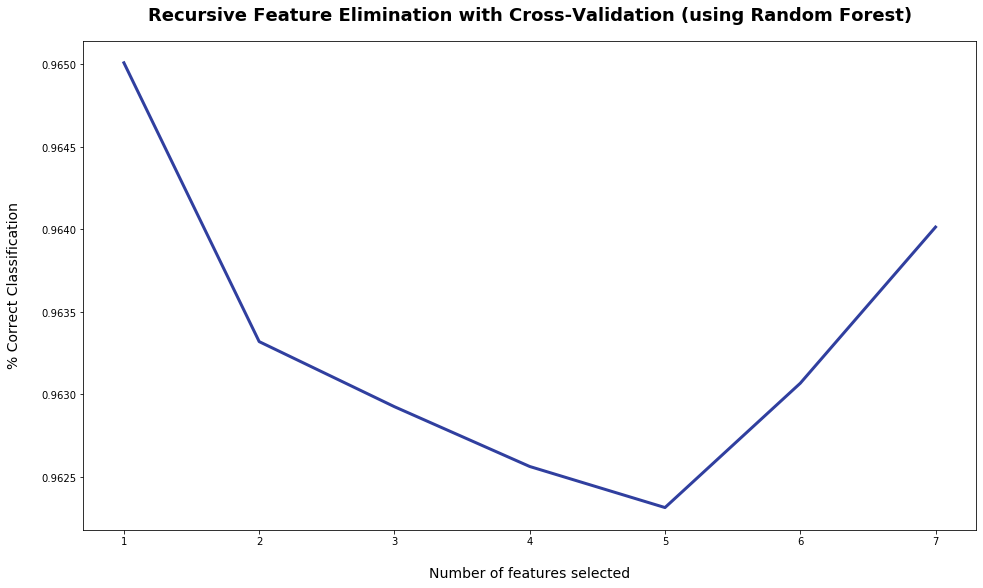

In [15]:
plot_acc_vs_num_features(
    rfecv.grid_scores_, 
    'Recursive Feature Elimination with Cross-Validation (using Random Forest)', 
)

## show feature ranking

In [16]:
print(dataframe.columns[list(map(lambda index: index - 1, rfecv.ranking_))])

Index(['D4', 'D11', 'D1', 'D15', 'D5', 'D10', 'D3'], dtype='object')


- based on optimal number of features, plot, as well as feature ranking, we should keep only D4
- however, the difference in accuracy is too little (max: ~0.9650, min: ~0.9623, use all 7 features: ~0.9640)

## result

- just exclude columns with high percentage of NaNs, since accuracy using the leftover D-features can still result in >96% accuracy
- apparently, [decision trees can deal with multicollinearity](https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4), so no need to worry about D2 being highly correlated to D1